In [1]:
import sys
sys.path.insert(0, '..')

import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from model import *
import glob
import os
from tqdm.auto import tqdm, trange
import seaborn as sns
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from utils import *
import scipy.io
from scipy.ndimage import shift
import gauss_psf_cuda as gauss_psf
import torch.nn as nn

import seaborn as sns
%load_ext autoreload
%autoreload 2

In [2]:
name = 'yingbi'
data_dir = f"/mnt/cfs/zhaobin/DFD/data/{name}X10"
sigma_fn = "sharps.mat"
aif_fn = "AIF.bmp"
depth_fn = 'depth.mat'
img_list = glob.glob(os.path.join(data_dir, '*.bmp'))
index = 150
img_list = sorted(img_list, key=lambda x: (x.split('/')[-1][:-4]).zfill(3))
aif = img_list.pop(-1)
n_img = len(img_list)

In [3]:
im = Image.open(os.path.join(img_list[index]))
img_all = np.array(im)[::2, ::2]
mat_all = (img_all.copy() / 255.).astype(np.float32)
mat_all.shape

(1024, 1296)

In [4]:
im = Image.open(os.path.join(data_dir, aif_fn))
img_aif = np.array(im)
mat_aif = (img_aif.copy() / 255.).astype(np.float32)[:, :, 0]
mat_aif.shape

(1024, 1296)

In [16]:
mat_dpt = scipy.io.loadmat(os.path.join(data_dir, depth_fn))
dpt = mat_dpt['depth']
dpt = dpt / np.max(dpt)
# sigma = 1 / sharps[:,:,index] / np.max(1 / sharps[:,:,index]) * 60
# data_path = os.path.join(data_dir, aif_fn)
# c_aif = Image.open(data_path).convert('RGB')
# c_aif = np.array(c_aif)

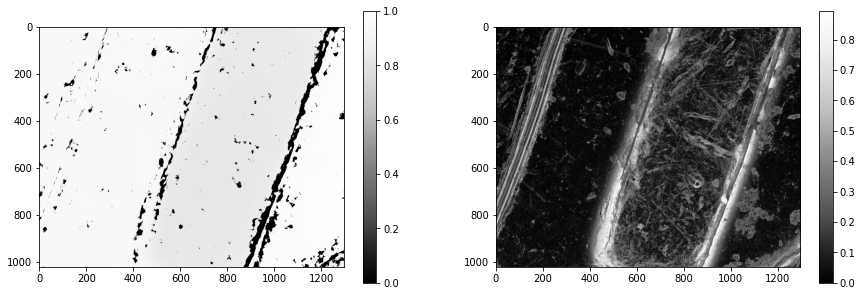

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(dpt, cmap='Greys_r')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(mat_aif, cmap='Greys_r')
plt.colorbar()

In [20]:
sections = np.array_split(np.arange(n_img), 5)
sample_imgs = np.sort([np.random.choice(sec) for sec in sections])
sample_imgs

array([ 10,  57,  99, 149, 162])

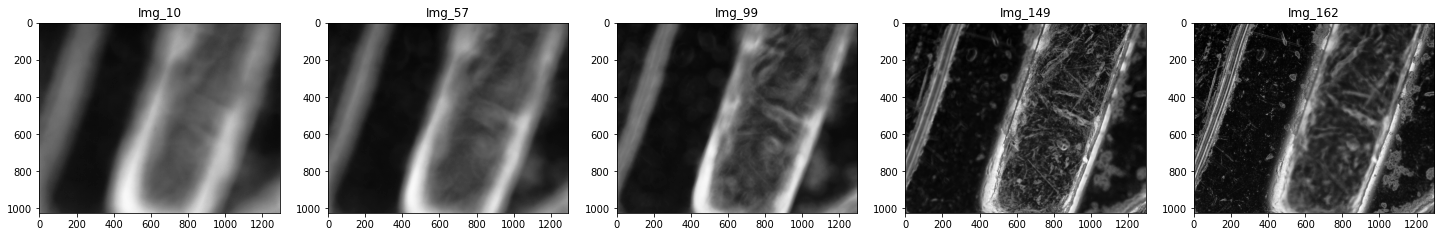

In [21]:
plt.figure(figsize=(25, 5))
for i in range(5):
    index = sample_imgs[i]
    im = Image.open(os.path.join(img_list[index]))
    img_all = np.array(im)[::2, ::2]
    mat_all = (img_all.copy() / 255.).astype(np.float32)
    plt.subplot(1,5,i+1)
    plt.imshow(mat_all, cmap='Greys_r')
    plt.title(f'Img_{index}')

In [22]:
def gradient(inp):
    D_dy = inp[:, :, :, :] - F.pad(inp[:, :, :-1, :], (0, 0, 1, 0))
    D_dx = inp[:, :, :, :] - F.pad(inp[:, :, :, :-1], (1, 0, 0, 0))
    return D_dx, D_dy

def sharpness(image):
    grad = gradient(image)
    mu = F.avg_pool2d(image, 7, 1, 7 // 2, count_include_pad=False) + 1e-8
    output = - (grad[0]**2 + grad[1]**2) - torch.abs((image - mu) / mu) - torch.pow(image - mu, 2)
    return output

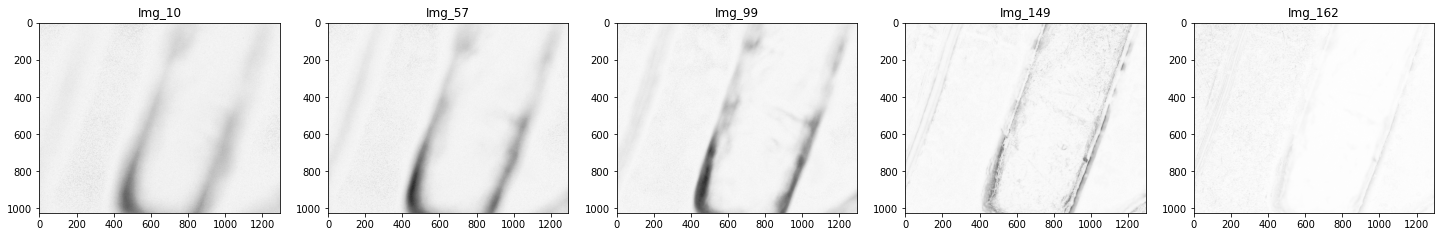

In [23]:
plt.figure(figsize=(25, 5))
for i in range(5):
    index = sample_imgs[i]
    im = Image.open(os.path.join(img_list[index]))
    img_all = np.array(im)[::2, ::2]
    mat_all = (img_all.copy() / 255.).astype(np.float32)
    mat_all_tensor = torch.from_numpy(mat_all).unsqueeze(0).unsqueeze(-1)
    sharp = sharpness(mat_all_tensor)
    plt.subplot(1,5,i+1)
    plt.imshow(sharp.squeeze().numpy(), cmap='Greys_r')
    plt.title(f'Img_{index}')